<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">






# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Projeto de Wrangling da operacao de entregas da Loggi na regiao do Distrito federal, a partir de um arquivo Json, gerando Dataframes e graficos, para retirada de insights


## 2\. Pacotes e bibliotecas

In [ ]:
# importando pacotes necessarios para Explor, Tratar, Manipular e visualizar do dados.

import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


## 3\. Exploração de dados

**3.1 - Carregando os dados de um arquivo Json.**




In [ ]:
!wget -q "/home/wbrito/Downloads/deliveries.json" -O deliveries.json
with open('/content/deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)


**3.2 - Wrangling**


*Convertendo para um Dataframe Pandas*

In [ ]:
# Wrangling da estrutura;
deliveries_df = pd.DataFrame(data)

deliveries_df

*As colunas Origin e Deliveires estão com os dados de latitude e longitude aninhados, fazendo a correcao (Flaten) usando a funcao json_normalize.*

In [ ]:
# Corrigindo a coluna Origin
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

In [ ]:
# Incluindo as novas colunas ao Dataframe original
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

In [ ]:
# Excluindo a coluna Origin e reorganizando e renomenando as colunas
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

In [ ]:
# Corrigindo a coluna Deliveries
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

In [ ]:
# Incluindo as novas colunas ao Dataframe original
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

**3.3 - Verificando a estrutura dos dados**

In [ ]:
# Verificando a estrutura do Dataframe
deliveries_df.shape

In [ ]:
deliveries_df.columns

In [ ]:
deliveries_df.index

In [ ]:
deliveries_df.info()

In [ ]:
deliveries_df.isna().any()

In [ ]:
deliveries_df[['delivery_size','vehicle_capacity']].describe().T

,count,mean,std,min,25%,50%,75%,max
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0


*Observações:*
1.   A Capacidade dos veiculos e a mesma para todos os Hubs, precisamos analisar se existe a necessidade de redistribuir os veículos entre os Hubs para melhoras na operação

2.  A variação ente a média, mediana e desvio padrão estao dentro da normalidade





In [ ]:
deliveries_df['region'].describe()

count     636149
unique         3
top         df-1
freq      304708
Name: region, dtype: object

*No arquivo analisado existem tres Hubs e o Hub "DF-1" concentra a maior quantidade de entregas.*'


## 4\. Manipulação

**4.1 Geocodificação reversa do hub (obter o endereço a partir das coordenadas)**

In [ ]:
# Obtendo as coordenadas dos Hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

In [ ]:
# Obtendo o endereço dos Hubs.
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

In [ ]:
# Incluindo as novas colunas ao Dataframe original
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

**4.2 Geocodificacao reversao das entregas**


In [ ]:
# Obtendo Cidade e Bairro das entregas
!wget -q "/home/wbrito/Downloads/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

In [ ]:
# Adcionando as novas colunas ao Dataframe original
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

In [ ]:
# Controle de qualidade;
deliveries_df.info()

In [ ]:
deliveries_df.isna().any()

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

## 5\. Visualização

**5.1 Mapa de entrega por regiao**

In [ ]:
# Obtendo mapa do Distrito Federal
#!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
# Obtendo a Geometria do Distrito Federal
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
# Obtendo a Geometria dos Hubs para inclusao no mapa das entregas
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

In [ ]:
# Obtendo a Geometria dos Pontos para inclusao no mapa das entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


**5.2 Visualizando o mapa das entregas**

In [ ]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

*Observações:*

*   No gráfico acima fica claro que o Hub "DF-1" possui o maior volume de entregas, sendo bastante concentrado, apesar de existir alguma dispersão.
*   O Hub "DF-2" tem o segundo maior volume e a relação entre a concentração e a dispersão ja e mais acentuada
*   O Hub "DF-3" alem de ter o menor volume de entregas, tem a maior dispersão de todos, o que poderia indicar uma necessidade menor de veiculos.



In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

**5.3 Visualizando Quantidade de Entrega dpo Hub**

In [ ]:
total_deliveries_df  = geo_deliveries_df.groupby('region')['delivery_size'].sum().reset_index()
total_deliveries_df.rename(columns={"delivery_size": "Quantidade_entrega"}, inplace=True)
total_deliveries_df

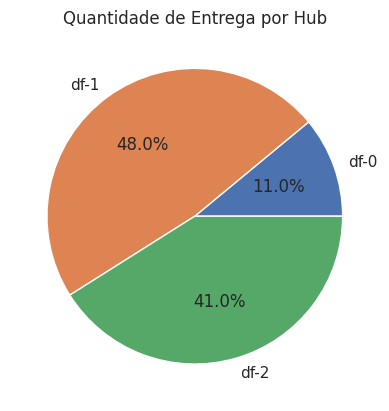

In [ ]:
plt.pie(total_deliveries_df['Quantidade_entrega'],
        labels=total_deliveries_df['region'], autopct='%1.1f%%')
plt.title("Quantidade de Entrega por Hub")
plt.show()

*Neste gráfico fica bastante evidente a a relação entre os Hubs e como o Hub "DF-1" responde por quase metade das entregas no Distrito Federal
*


**5.4 Visualizando Entrega por Regiao Administrativa (RA)**


In [ ]:
# Relacao entre por Hub X RA
Top5_entrega_df = deliveries_df.groupby(['region','delivery_city'])['delivery_size'].sum().reset_index().sort_values(by = 'delivery_size', ascending = False).head(15)


In [ ]:
Top5_entrega_df

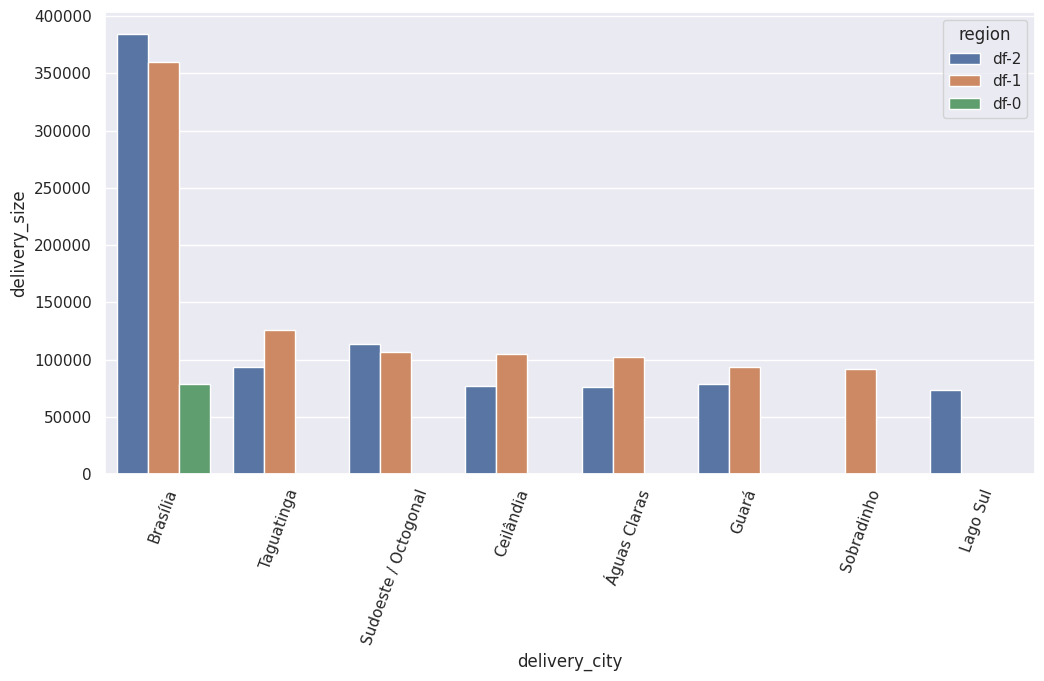

In [ ]:
# Plot
plt.figure(figsize = (12, 6))
sns.set()
fig1 = sns.barplot(data = Top5_entrega_df,
                   y = 'delivery_size',
                   x = 'delivery_city',
                   hue = 'region')
                   #col = anos,
                   #col_wrap = 2)
plt.xticks(rotation = 70)
plt.show()

*Mais uma demonstração da relação entre os Hubs e as entregas, demonstrando o volume de entrega nas 15 maiores Regiões Administrativas, onde podemos observar que os 3 Hubs fazem entregas em "Brasilia" e que o Hub "DF-3" aparece com apenas uma RA entre as maiores e as demais regiões ficam divididas de uma forma equilibrada entre os outros Hubs*


**Conclusao**
*Após todo o processo de tratamento, limpeza e enrequecimento dos dados, podemos constatar que a Logística da **Loggi**  atende todo o território do Distrito Federal, que o maior volume se concentra na regiao central e que ocorre de forma bastante pulverizada nas regiões mais distantes, em relacao a capacidade dos veículos do Hub "DF-3" nao foi possivel determinar se havia a possibilidade de remanejar para os outros Hubs, por conta do menor volume de entrega, em função das distancias da área atendida.*
